In [1]:
from IPython.display import clear_output

!pip install transformers
clear_output()

# **IMPORTING THE LIBRARIES**

In [3]:
import pandas as pd
import numpy as np
import os
import json
import csv 
import pickle

import torch
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import random
import re
import pickle
import torch
import nltk
nltk.download('punkt',quiet=True)
from tqdm.autonotebook import tqdm
from transformers import AutoTokenizer,AutoModel
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader

model_name='bert-base-uncased'

tokenizer=AutoTokenizer.from_pretrained(model_name)

if torch.cuda.is_available():       
    device = torch.device("cuda:0")
    #torch.set_cuda_device(0)

else:
  device = torch.device("cpu")


In [4]:
cd /content/drive/MyDrive/absa

/content/drive/MyDrive/absa


# **DATA LOADING**

In [5]:
input_path='data/train_data.csv'
data=pd.read_csv(input_path)

x=data.iloc[:,:-1]
y=data.iloc[:,-1]

from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.10,random_state=42)

print(f"SIZE OF \nX_TRAIN: {x_train.shape }\nY_TRAIN: {y_train.shape } \nX_TEST : {x_test.shape}\nY_TEST : {y_test.shape}")


with open("models/embeddings_train_100.pickle",'rb') as out:
  embeddings=pickle.load(out)

with open("models/vocab_train_100.pickle",'rb') as out:
  vocab=pickle.load(out)

word_to_ix={word:i for i,word in enumerate(vocab)}
VOCAB_LEN=len(word_to_ix)


SIZE OF 
X_TRAIN: (3600, 2)
Y_TRAIN: (3600,) 
X_TEST : (400, 2)
Y_TEST : (400,)


# **DATA LOADER**

In [6]:


class Data(Dataset):
    def __init__(self,sentences,names,sentiment):

        self.sentences = sentences
        self.names     = names
        self.labels    = list(sentiment)
        self.size=len(sentences)

    def preprocess_text(self,string:str):
        string=string.lower()
        punctuations = '''!()-[]{};:'"\<>/?@#$^&*_~'''
        string=string.replace('’'," ")
        string=string.replace('\n',"")
        for x in string.lower(): 
            if x in punctuations: 
                string = string.replace(x, " ") 

        return string

    def tokenize_embedding(self,t):
      t=self.preprocess_text(t)
      s=nltk.word_tokenize(t)

      k=[]
      if(len(s)<=40):
        s=s+['<pad>']*(40-len(s))

      else:
        s=s[0:40]

      for w in s:
        if (w not in word_to_ix.keys()):
          k.append(1)

        else:
          k.append(word_to_ix[w])

      k=torch.tensor(k,dtype=torch.long)
      return k

    
    def tokenize_embedding_name(self,t):
      t=self.preprocess_text(t)
      s=nltk.word_tokenize(t)

      k=[]
      if(len(s)<=5):
        s=s+['<pad>']*(5-len(s))

      else:
        s=s[0:5]

      for w in s:
        if (w not in word_to_ix.keys()):
          k.append(1)

        else:
          k.append(word_to_ix[w])

      k=torch.tensor(k,dtype=torch.long)
      return k


    def __getitem__(self,idx):

        sen=self.sentences[idx]
        na =self.names[idx].lower()


        return {'ids':self.tokenize_embedding(sen),
                'ids_name':self.tokenize_embedding_name(na),
                'targets':self.labels[idx]}

    def __len__(self):
        return self.size

def getLoaders (batch_size):

        print('Reading the training Dataset...')
        train_dataset = Data(list(x_train['text']),list(x_train['aspect']),y_train) #19200 #21216
        
        print('Reading the validation Dataset...')
        valid_dataset = Data(list(x_test['text']),list(x_test['aspect']),y_test) #23200 #25216

        
        trainloader = DataLoader(dataset=train_dataset, batch_size = batch_size, num_workers=8,shuffle=True)
        validloader = DataLoader(dataset=valid_dataset, batch_size = batch_size, num_workers=8,shuffle=True)
        
        return trainloader, validloader

trainloader, validloader = getLoaders(batch_size=16)

print("Length of TrainLoader:",len(trainloader))
print("Length of ValidLoader:",len(validloader))

Reading the training Dataset...
Reading the validation Dataset...
Length of TrainLoader: 225
Length of ValidLoader: 25


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# **defining the model**

In [9]:
class BertModel(nn.Module):
    def __init__(self,out_features):

        super(BertModel, self).__init__()
        weights_matrix=torch.from_numpy(embeddings).float().to(device)

        self.embedding =nn.Embedding.from_pretrained(weights_matrix,freeze=False)
        self.out_features = out_features    
        self.lstm =nn.LSTM(100,50//2,batch_first=True,num_layers=1,bidirectional=True)
        self.flatten=nn.Flatten()
        self.dropout1=nn.Dropout(0.1)

        self.linear1=nn.Linear(150,32*2)
        self.linear2=nn.Linear(32*2,16*2)
        self.linear3=nn.Linear(16*2,8*2)
        self.last_dense = nn.Linear(8*2, self.out_features)
        self.relu = nn.ReLU()

    def forward(self, t,t1):
        
        encoding=self.embedding(t)
        encoding_name=self.embedding(t1).squeeze(dim=1) 

        l=self.lstm(encoding)[0]
        l=torch.mean(l,dim=1) 
        encoding_name=torch.mean(encoding_name,dim=1)

        l=torch.cat((encoding_name,l),dim=1) 

        l = self.relu(self.linear1(l)) 
        l = self.dropout1(l)
        l = self.relu(self.linear2(l)) 
        l = self.relu(self.linear3(l))
        l = self.dropout1(l)
        model_output = torch.nn.functional.softmax(self.last_dense(l),dim=1)
        
        return model_output


# **MODEL TRAINING AND EVALUATION**

Train epoch 1/30:   0%|          | 0/225 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1, loss: 1.0571006462309096, val_loss: 1.0181257033348083



Train epoch 2/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2, loss: 0.9641015219688416, val_loss: 0.9423935890197754



Train epoch 3/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3, loss: 0.8806295667754279, val_loss: 0.8682706522941589



Train epoch 4/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4, loss: 0.8108026946915521, val_loss: 0.8523128390312195



Train epoch 5/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5, loss: 0.7829182611571418, val_loss: 0.8428432369232177



Train epoch 6/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6, loss: 0.7517137365871006, val_loss: 0.837873682975769



Train epoch 7/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7, loss: 0.731784594853719, val_loss: 0.8338528490066528



Train epoch 8/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8, loss: 0.7214364971054925, val_loss: 0.8361385488510131



Train epoch 9/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9, loss: 0.7040580582618713, val_loss: 0.8261961507797241



Train epoch 10/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10, loss: 0.7066665400399103, val_loss: 0.8320764446258545



Train epoch 11/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 11, loss: 0.6943682471911112, val_loss: 0.8503723073005677



Train epoch 12/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 12, loss: 0.6946609338124593, val_loss: 0.8453701496124267



Train epoch 13/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 13, loss: 0.689367205037011, val_loss: 0.8458771300315857



Train epoch 14/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 14, loss: 0.6830627089076572, val_loss: 0.8338006496429443



Train epoch 15/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 15, loss: 0.6781622007158068, val_loss: 0.8425552868843078



Train epoch 16/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 16, loss: 0.6709950455029805, val_loss: 0.8253064966201782



Train epoch 17/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 17, loss: 0.672377875910865, val_loss: 0.8474506616592408



Train epoch 18/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 18, loss: 0.6672214741177029, val_loss: 0.857146532535553



Train epoch 19/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 19, loss: 0.6937112450599671, val_loss: 0.8725712513923645



Train epoch 20/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 20, loss: 0.7021292320887248, val_loss: 0.8622312355041504



Train epoch 21/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 21, loss: 0.6706953676541646, val_loss: 0.861876745223999



Train epoch 22/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 22, loss: 0.6629553967052035, val_loss: 0.8504562044143676



Train epoch 23/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 23, loss: 0.660812312497033, val_loss: 0.8480906009674072



Train epoch 24/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 24, loss: 0.65834089173211, val_loss: 0.8281069207191467



Train epoch 25/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 25, loss: 0.6522952432102628, val_loss: 0.8275197291374207



Train epoch 26/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 26, loss: 0.6537312483787536, val_loss: 0.8241540884971619



Train epoch 27/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 27, loss: 0.6616093354754978, val_loss: 0.8587696766853332



Train epoch 28/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 28, loss: 0.6464120353592767, val_loss: 0.8627014183998107



Train epoch 29/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 29, loss: 0.6479384186532763, val_loss: 0.8461585855484008



Train epoch 30/30:   0%|          | 0/225 [00:00<?, ?it/s]

Epoch 30, loss: 0.6456532759136624, val_loss: 0.8411629176139832

Training...
[0.91289894 0.91818182 0.87810384]
0.9061111111111111
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1501
           1       0.89      0.95      0.92      1170
           2       0.92      0.84      0.88       929

    accuracy                           0.91      3600
   macro avg       0.91      0.90      0.90      3600
weighted avg       0.91      0.91      0.91      3600


Validation...
[0.72891566 0.69144981 0.70351759]
0.71
              precision    recall  f1-score   support

           0       0.79      0.68      0.73       179
           1       0.64      0.75      0.69       124
           2       0.69      0.72      0.70        97

    accuracy                           0.71       400
   macro avg       0.71      0.72      0.71       400
weighted avg       0.72      0.71      0.71       400



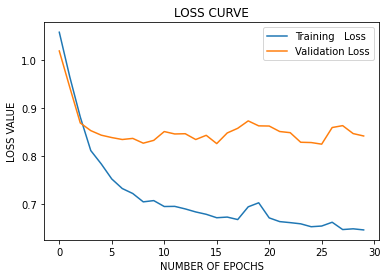

In [10]:

text_model = BertModel(3)
text_model.to(device)
criterion = nn.CrossEntropyLoss()


optimizer = torch.optim.Adam(text_model.parameters(),lr=0.001)#,weight_decay=3e-5)
result=[]
EPOCH=30


train_out = []
val_out = []
train_true = []
val_true = []

loss_log1 = []
loss_log2 = []


for epoch in range(EPOCH):

  final_train_loss=0.0
  final_val_loss=0.0
  l1 = []
  text_model.train()

  for data in tqdm(trainloader,desc="Train epoch {}/{}".format(epoch + 1, EPOCH)):

    ids = data['ids'].to(device,dtype = torch.long)
    targets = data['targets'].to(device,dtype = torch.long)
    ids_name = data['ids_name'].to(device,dtype = torch.long)
    

    optimizer.zero_grad()
    out= text_model(ids,ids_name)


    loss = criterion(out, targets)
    l1.append(loss.item())
    final_train_loss +=loss.item()

    if (epoch+1 == EPOCH):
      train_out.append(torch.transpose(out,0,1).detach().cpu())
      train_true.append(torch.transpose(targets.unsqueeze(1),0,1).detach().cpu())

    loss.backward()
    optimizer.step()
    
  loss_log1.append(np.average(l1))

  text_model.eval()
  l2 = []
  with torch.no_grad():
    for data in validloader:
      ids = data['ids'].to(device,dtype = torch.long)
    
      targets = data['targets'].to(device,dtype = torch.long)
      ids_name = data['ids_name'].to(device,dtype = torch.long)
      optimizer.zero_grad()
      
      out_val= text_model(ids,ids_name)
      
      loss = criterion(out_val, targets)
      l2.append(loss.item())
      final_val_loss+=loss.item()

      if (epoch+1 == EPOCH):
        val_out.append(torch.transpose(out_val,0,1).detach().cpu())
        val_true.append(torch.transpose(targets.unsqueeze(1),0,1).detach().cpu())


  loss_log2.append(np.average(l2))
  curr_lr = optimizer.param_groups[0]['lr']

  print("Epoch {}, loss: {}, val_loss: {}".format(epoch+1, final_train_loss/len(trainloader), final_val_loss/len(validloader)))
  print()


plt.plot(range(len(loss_log1)), loss_log1,label= "Training   Loss")
plt.plot(range(len(loss_log2)), loss_log2,label= "Validation Loss")
plt.xlabel("NUMBER OF EPOCHS")
plt.ylabel("LOSS VALUE")
plt.title("LOSS CURVE")
plt.legend(loc="upper right")


train_out2 =torch.max(torch.cat(train_out, 1),0)[1]
val_out2 = torch.max(torch.cat(val_out, 1),0)[1]

train_true1 = torch.cat(train_true, 1)
val_true1 = torch.cat(val_true, 1)


def labelwise_metrics(pred, true):
  from sklearn.metrics import accuracy_score
  from sklearn.metrics import f1_score,classification_report 

  pred = pred.to(torch.int).tolist()
  true = true.to(torch.int).tolist()[0]

  acc=accuracy_score(true,pred)
  print(f1_score(true,pred,average=None))
  print(acc)
  print(classification_report(true,pred))



print('Training...')
labelwise_metrics(train_out2, train_true1)
print()
print('Validation...')
labelwise_metrics(val_out2, val_true1)


# **SAVING THE MODEL**

In [11]:
torch.save(text_model.state_dict(),"models/intern_model_state_dict.pt")

# **SOME BASIC STATS FOR VALIDATION SET**  

In [12]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


pred_val = val_out2.to(torch.int).tolist()
true_val = val_true1.to(torch.int).tolist()[0]


print("TOTAL-LABELS NEGATIVE", true_val.count(0))
print("TOTAL-LABELS NEUTRAL", true_val.count(1))
print("TOTAL-LABELS POSITIVE", true_val.count(2))


count0=0
count1=0
count2=0

for p,p_t in zip(pred_val,true_val):
  if(p==p_t and p==0):
    count0+=1
  if(p==p_t and p==1):
    count1+=1
  if(p==p_t and p==2):
    count2+=1


print()
print("TOTAL-PRED_LABELS NEGATIVE",  count0)
print("TOTAL-PRED_LABELS NEUTRAL", count1)
print("TOTAL-PRED_LABELS POSITIVE", count2)



TOTAL-LABELS NEGATIVE 179
TOTAL-LABELS NEUTRAL 124
TOTAL-LABELS POSITIVE 97

TOTAL-PRED_LABELS NEGATIVE 121
TOTAL-PRED_LABELS NEUTRAL 93
TOTAL-PRED_LABELS POSITIVE 70
